# 0) EDA

## Load Dataset

In [1]:
import nltk
import os, sys
import pandas as pd
import pickle

from matplotlib import pyplot as plt
from nltk.corpus import stopwords
from pathlib import Path

In [2]:
tv_show = "friends"

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

root_path = Path().resolve().joinpath("..")
show_data_path = root_path.joinpath("scrape", "data", tv_show, "parsed")

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load the Training Data

In [4]:
dialog_datas = []

# take all the separate CSV files and put them together into a single dataframe
for filename in os.listdir(show_data_path):
    dialog_data = pd.read_csv(show_data_path.joinpath(filename), header=None, names=("speaker", "utterance"))
    dialog_data["episode"] = filename.split(".")[0]
    dialog_datas.append(dialog_data)
    
all_dialog_data = pd.concat(dialog_datas) \
                    .dropna() \
                    .sample(frac=1) \
                    .reset_index(drop=True)

In [5]:
print(all_dialog_data.count())
all_dialog_data.head()

speaker      55025
utterance    55025
episode      55025
dtype: int64


,speaker,utterance,episode
0,Phoebe,Is that Ross?,1001
1,Phoebe,"Well, how much do you think he needs?",0606
2,Phoebe,"Wow! Well, if you nail the interview, you'll g...",0517
3,Chandler,No sir.,0324
4,Chandler,"Okay! Now you stay out here, and you think abo...",0321


## Data Pre-processing and Minor Analysis

We'll count how many lines of dialog each character has. We need to subset the number of classes, taking only the top $n$ most common.

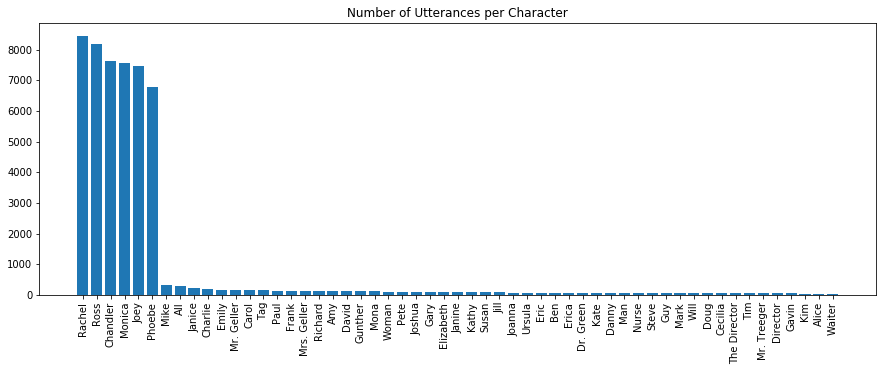

In [6]:
speaker_value_counts = all_dialog_data.speaker.value_counts()
major_speaker_value_counts = speaker_value_counts[speaker_value_counts > 40]
x, y = major_speaker_value_counts.index, major_speaker_value_counts.values

fig = plt.figure(figsize=(15, 5))
sub = fig.add_subplot(111)
sub.bar(x, y)
for tick in sub.get_xticklabels():
    tick.set_rotation(90)
plt.title("Number of Utterances per Character")
plt.show()

The number of characters will be in the `num_major_characters` variable, and can be changed.

In [7]:
num_major_characters = 6

# a list of the top characters names
major_characters = x[:num_major_characters]
# a set of those same names
major_characters_set = set(major_characters)

# finally, dicts to and from class Ids and their respective names
labels_to_ids = {}
ids_to_labels = {}
for i, major_character in enumerate(major_characters):
    labels_to_ids[major_character] = i
    ids_to_labels[i] = major_character
labels_to_ids

{'Rachel': 0, 'Ross': 1, 'Chandler': 2, 'Monica': 3, 'Joey': 4, 'Phoebe': 5}

Cut the data to only the major characters

In [8]:
major_dialog_data = all_dialog_data[all_dialog_data.speaker.isin(major_characters_set)]
print(major_dialog_data.count())

speaker      46079
utterance    46079
episode      46079
dtype: int64


In [9]:
tokenizer = nltk.tokenize.TreebankWordTokenizer()

labels = major_dialog_data.speaker

# tokenize the data into a nested list
utterances = [tokenizer.tokenize(utter.lower()) for utter in major_dialog_data.utterance]

Text(0.5,1,'Histogram of Utterance lengths')

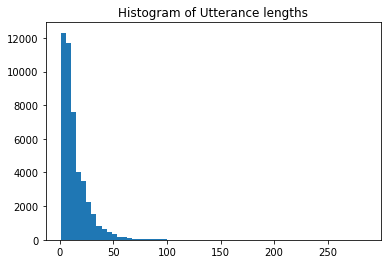

In [10]:
plt.hist([len(words) for words in utterances], bins=60)
plt.title("Histogram of Utterance lengths")

### Save dataset for other notebooks

In [11]:
!mkdir -p datasets

major_dialog_data.to_pickle("./datasets/major_dialog_data.pkl")
all_dialog_data.to_pickle("./datasets/all_dialog_data.pkl")

with open('./datasets/utterances.pkl', 'wb') as f:  
    pickle.dump(utterances, f)
    
with open('./datasets/stop_words.pkl', 'wb') as f:
    pickle.dump(stop_words, f)